Develops a custom convolutional neural network (CNN) to classify Alzheimer's disease, focusing on:
- Class weighting to address class imbalance
- Hyperparameter tuning
- Distributed training using TensorFlow's MirroredStrategy
- The effect of class imbalance on class-specific classification accuracy

In [2]:
# "standard"
import numpy as np

# machine learning and statistics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

# misc
from IPython.display import clear_output

# src
import sys, pickle, os
from pathlib import Path
script_dir = Path(os.getcwd()).parent
src_dir = script_dir / 'src'
sys.path.append(str(src_dir))
from visualize import visualize_training, multiclass_summary

clear_output(wait=False)

Create results directory

In [33]:
script_dir = Path(os.getcwd()).parent
results_dir_00 = script_dir / 'results' / 'notebook_00'

results_dir_02 = script_dir / 'results' / 'notebook_02'
os.makedirs(results_dir_02, exist_ok=True)

In [34]:
# Load data file and unpack contents
file_name = results_dir_00 / 'data_preprocessed.pkl'
with open(file_name, 'rb') as f:
    data_preproc = pickle.load(f)

train_data=data_preproc['train_data']
train_lab=data_preproc['train_labels']
test_data=data_preproc['test_data']
test_lab=data_preproc['test_labels']
class_lab = ['Mild', 'Moderate', 'None', 'Very Mild']
    
# Convert labels to categorical
train_lab_cat = to_categorical(train_lab.astype('int8'), num_classes=4)
test_lab_cat = to_categorical(test_lab.astype('int8'), num_classes=4)

Define custom CNN and distributed training strategy

In [35]:
def create_model():
    # three convolutional layers and one fully connected layer
    model = keras.Sequential([
        keras.Input(shape = (128, 128, 1)),

        keras.layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(
            filters=64, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(
            filters=128, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'), # fully connected layer
        keras.layers.Dense(4, activation='softmax')
    ])
    return model

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = create_model()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

clear_output(wait=False)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,484 (24.86 MB)

 Trainable params: 6,516,484 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Fit model

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
validation_data = (test_data, test_lab_cat)

history = model.fit(
    train_data, 
    train_lab_cat, 
    epochs=50, 
    batch_size=32, 
    validation_data=validation_data, 
    callbacks=[early_stopping]
)

clear_output(wait=False)

In [37]:
# Save model and history files
model.save(results_dir_02 / 'model_custom_CNN.h5')
print(f"Model saved to {results_dir_02 / 'model_custom_CNN.h5'}")

file_name = results_dir_02 / 'history_custom_CNN.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(history, f)

print(f"Data saved to {file_name}")

Model saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\model_custom_CNN.h5
Data saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\history_custom_CNN.pkl


Visualize model fit

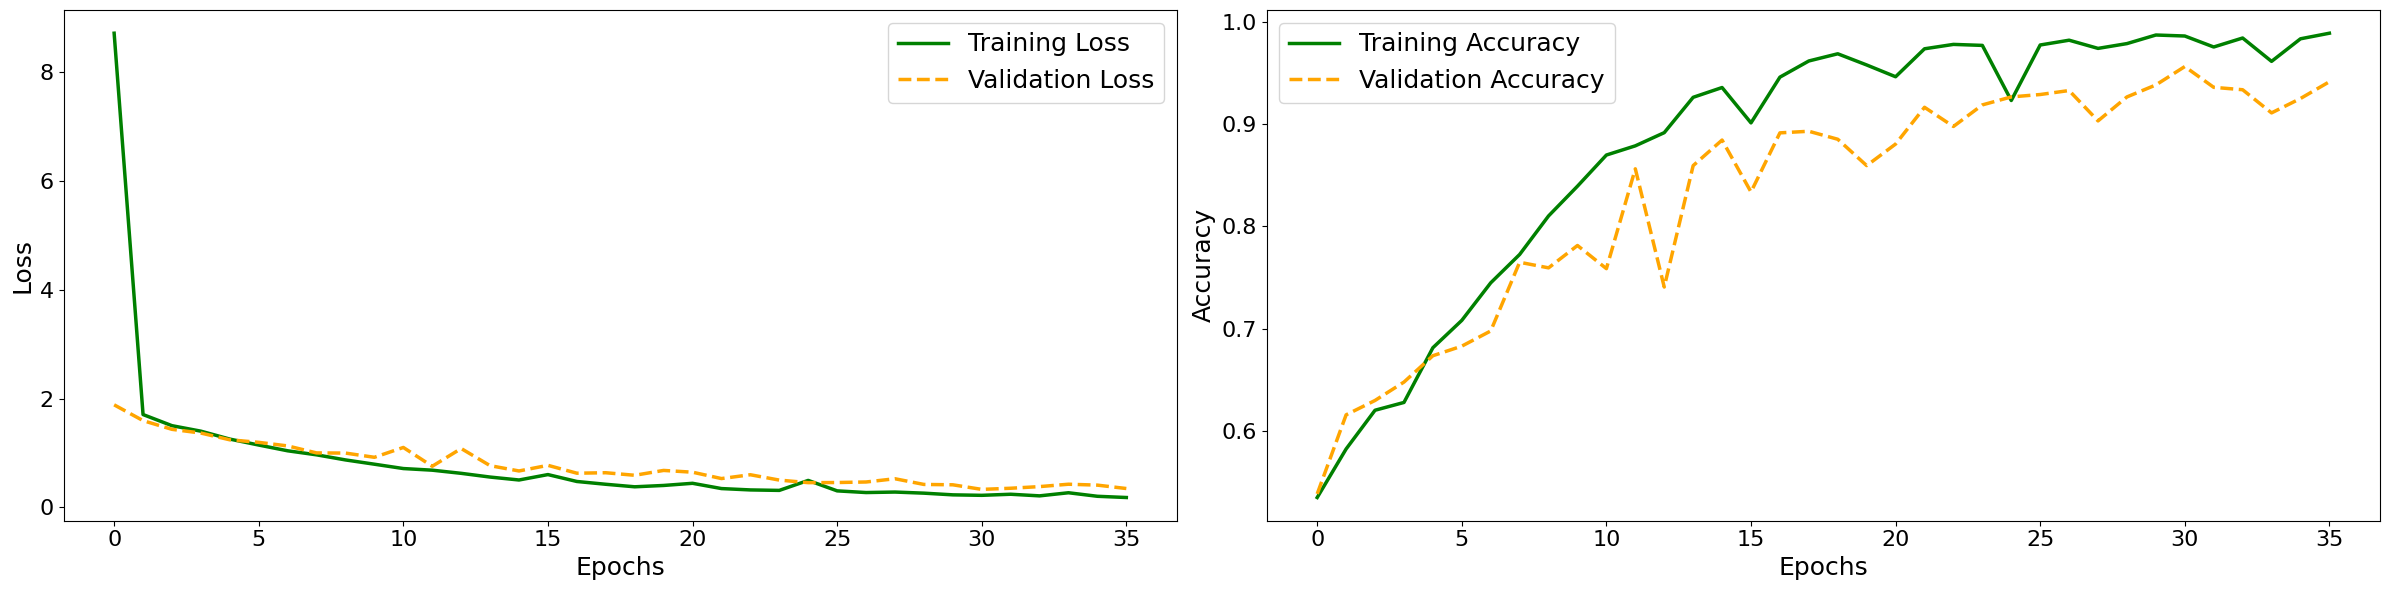

In [38]:
file_name = results_dir_02 / 'history_custom_CNN.pkl'
with open(file_name, 'rb') as f:
    history = pickle.load(f)
clear_output(wait=False)

visualize_training(history)

Predict test data, evaluate accuracy and visualize


Overall classification accuracy is: 95.62 %



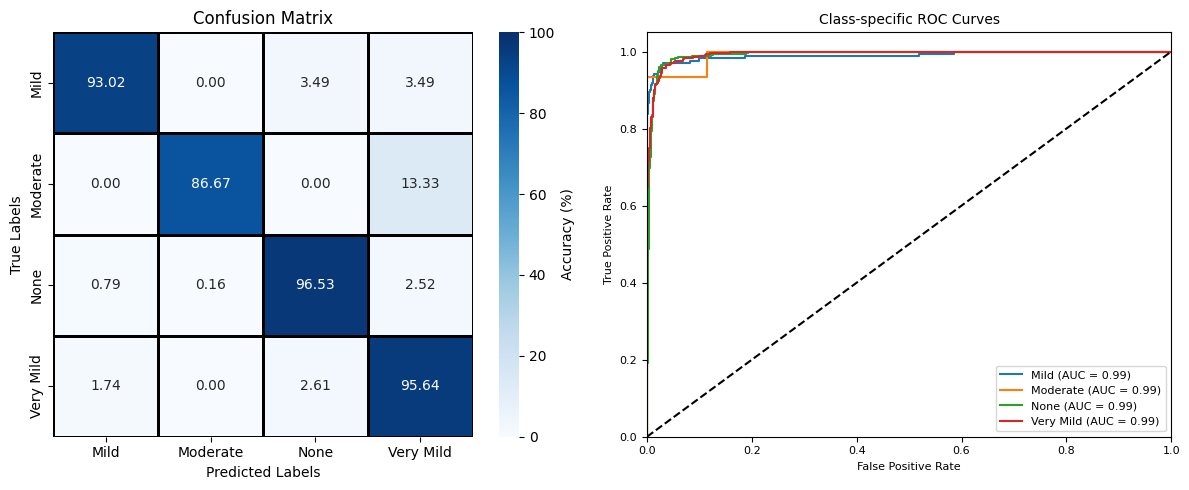

Mild - Precision: 0.92, Recall: 0.93, F1 Score: 0.93
Moderate - Precision: 0.93, Recall: 0.87, F1 Score: 0.90
None - Precision: 0.97, Recall: 0.97, F1 Score: 0.97
Very Mild - Precision: 0.95, Recall: 0.96, F1 Score: 0.95



In [ ]:
# Load model
model = load_model(results_dir_02 / 'model_custom_CNN.h5')

# Predict test data
prob = model.predict(test_data)
clear_output(wait=False)
predict_classes = np.argmax(prob, axis=1)
result = predict_classes - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary, 0)
acc=correct/test_lab.shape[0] * 100

print()
print(f"Overall classification accuracy is: {acc:.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(prob, test_lab, class_lab)
print()


Overall, here we see a direct link between the test set class accuracies and the number of measurements in the training set. For example, the majority class (no AD) exhibited the highest accuracy and the minority class (moderate AD) exhibited the lowest. I believe the correspondence between accuracy and class size is a coincidence, but still seems to make sense due to the obvious class imbalance. Therefore, next we train with class weights to account for the imbalance by giving more importance to underrepresented classes during training.

In [ ]:
# Use same model architecture from before
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model_weighted = create_model()
    model_weighted.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_lab),
    y=train_lab
)
class_weights_dict = dict(zip(np.unique(train_lab), class_weights))

# Train with class weights
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
validation_data = (test_data, test_lab_cat)

history_weighted = model_weighted.fit(
    train_data,
    train_lab_cat,
    epochs=50,
    batch_size=32,
    validation_data=validation_data,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
    )

clear_output(wait=False)

In [41]:
# Save model and history files
model_weighted.save(results_dir_02 / 'model_custom_CNN_weighted.h5')
print(f"Model saved to {results_dir_02 / 'model_custom_CNN_weighted.h5'}")

file_name = results_dir_02 / 'history_custom_CNN_weighted.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(history_weighted, f)

print(f"Data saved to {file_name}")

Model saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\model_custom_CNN_weighted.h5
Data saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\history_custom_CNN_weighted.pkl


Visualize weighted model fit

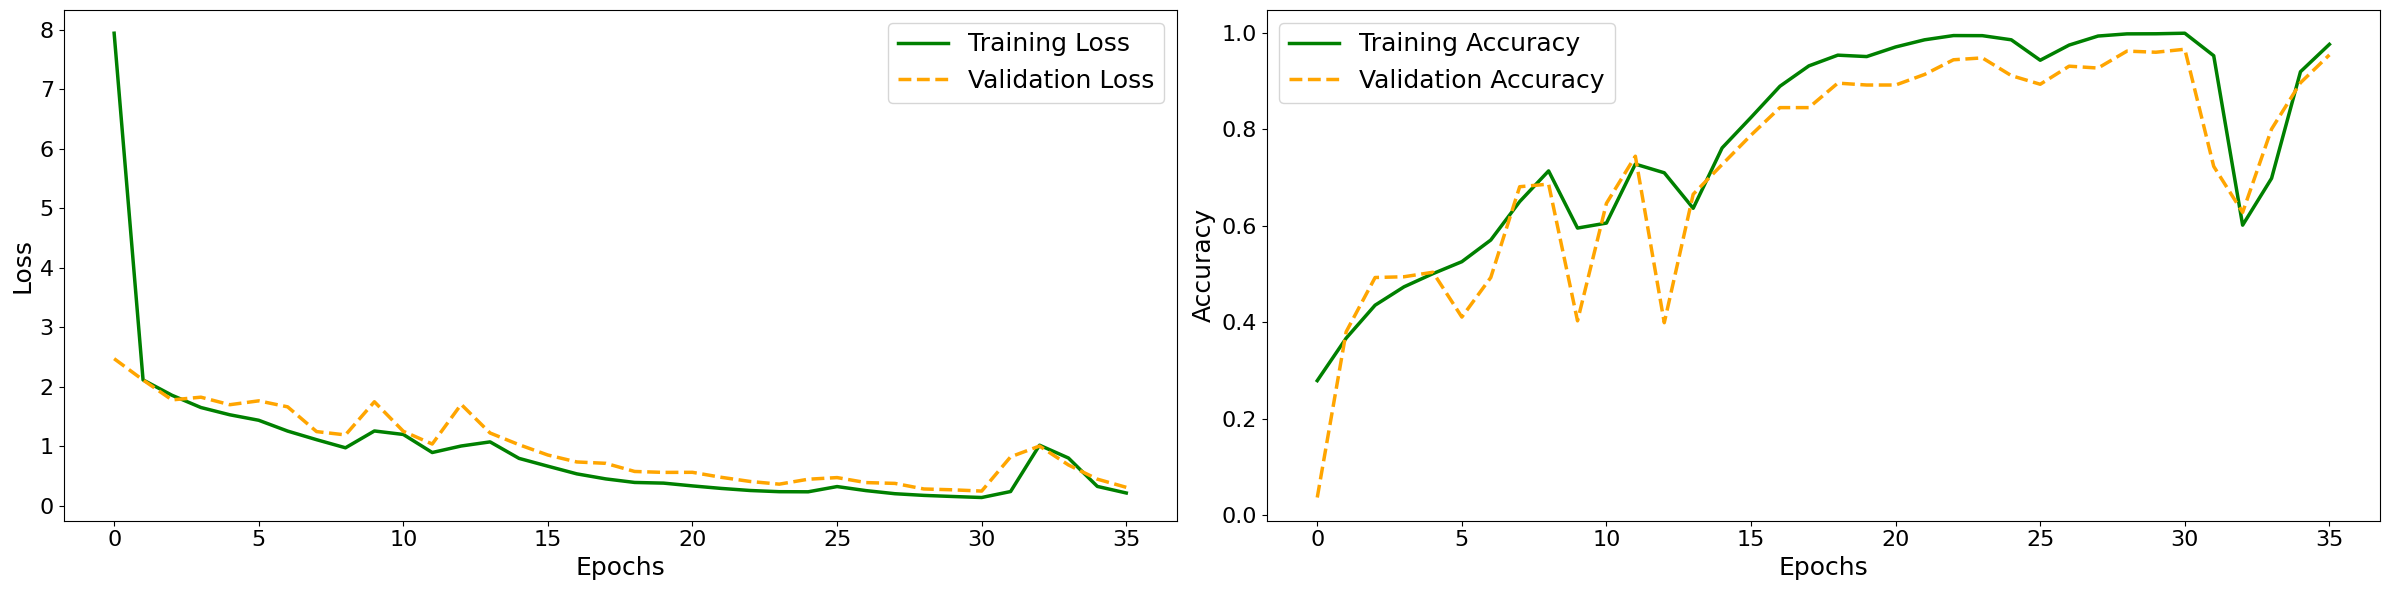

In [42]:
file_name = results_dir_02 / 'history_custom_CNN_weighted.pkl'
with open(file_name, 'rb') as f:
    history_weighted = pickle.load(f)
clear_output(wait=False)

visualize_training(history_weighted)

Predict test data, evaluate accuracy and visualize


Overall classification accuracy is: 96.64 %



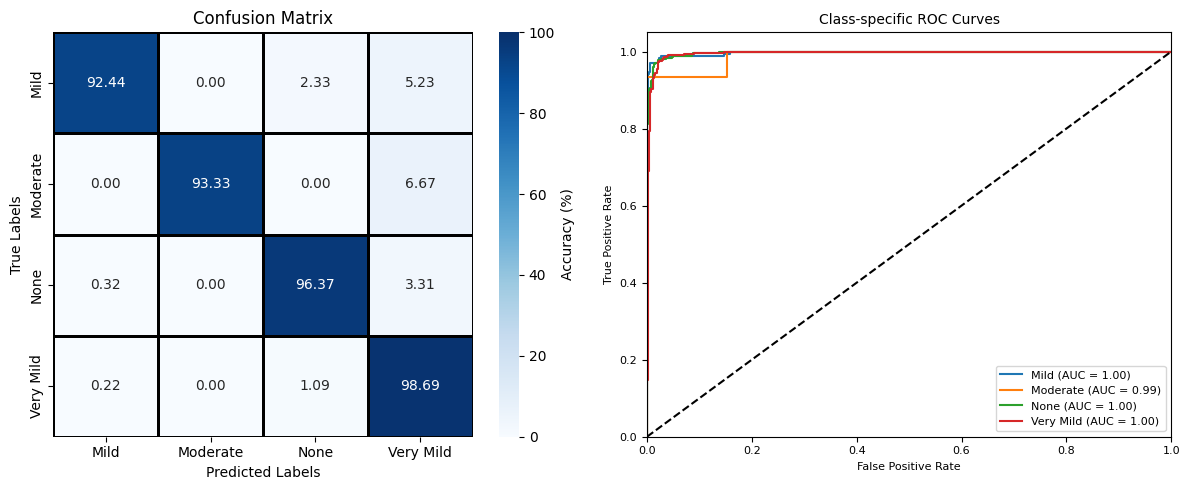

Mild - Precision: 0.98, Recall: 0.92, F1 Score: 0.95
Moderate - Precision: 1.00, Recall: 0.93, F1 Score: 0.97
None - Precision: 0.99, Recall: 0.96, F1 Score: 0.97
Very Mild - Precision: 0.94, Recall: 0.99, F1 Score: 0.96



In [43]:
# Load model
model_weighted = load_model(results_dir_02 / 'model_custom_CNN_weighted.h5')

# Predict test data
prob = model_weighted.predict(test_data)
clear_output(wait=False)
predict_classes = np.argmax(prob, axis=1)
result = predict_classes - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary, 0)
acc=correct/test_lab.shape[0] * 100

print()
print(f"Overall classification accuracy is: {acc:.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(prob, test_lab, class_lab)
print()

When using class weighting, we see a slight accuracy improvement and more balanced accuracy values across individual classes. Nevertheless, while class imbalance has been addressed via class weighting, the current CNN has been trained using relatively arbitrary parameters. As was done with the Random Forest classifier, we need to tune the parameters to further optimize performance. Therefore, next we redefine the CNN exactly as was done before, but now also specify the parameter space associated with different hyperparameters that we want to tune.

In [44]:
# Same architecture as before, but with hyperparameter ranges
def build_model(hp):

    model = keras.Sequential([
    keras.Input(shape = (128, 128, 1)),  
        
    keras.layers.Conv2D(
        filters = hp.Int('conv_1_filter', min_value = 32, max_value = 128, step = 32), 
        kernel_size = hp.Choice('conv_1_kernel', values = [3,3]), 
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_2_filter', min_value = 64, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_2_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_3_filter', min_value = 96, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_3_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D((2, 2)),
        
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value = 128, max_value = 256, step = 32),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
        
    keras.layers.Dropout(0.5),
        
    keras.layers.Dense(4, activation = 'softmax')
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

Initiate tuner

In [57]:
script_dir = Path(os.getcwd()).parent
tuner_dir = script_dir / 'results' / 'notebook_02' / 'tuner_dir'
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20, factor=3,
    directory=tuner_dir,
    project_name='AD_class',
    overwrite=True
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Run search

In [58]:
# Tune parameters on subset of data to conserve time/memory
subset = []
for label in np.unique(train_lab):
    label_indices = np.where(train_lab == label)[0]
    np.random.shuffle(label_indices)
    subset.extend(label_indices[:int(0.25 * len(label_indices))])
subset = np.array(subset)
train_data_tune = train_data[subset,:,:]
train_lab_tune = train_lab[subset]

# Plot bar graph of label distribution in subset
label_counts = np.bincount(train_lab_tune)
labels = np.arange(len(label_counts))

train_lab_tune_cat = to_categorical(train_lab_tune.astype('int8'))
test_data_tune = test_data
test_lab_tune_cat = to_categorical(test_lab.astype('int8'))

# Compute class weights
class_weights_tune = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_lab_tune),
    y=train_lab_tune
)
class_weights_dict_tune = dict(enumerate(class_weights_tune))

In [59]:
tuner.search(
    train_data_tune,
    train_lab_tune_cat,
    epochs = 25,
    validation_data = (test_data_tune, test_lab_tune_cat),
    class_weight = class_weights_dict_tune
)

Trial 30 Complete [00h 03m 54s]
val_accuracy: 0.4921875

Best val_accuracy So Far: 0.6734374761581421
Total elapsed time: 02h 19m 32s


Even though this accuracy is lower than expected given the previous results, tuning was performed on a subset of training data and with fewer training epochs to conserve time and memory. Despite this reduced training set, teh data was randomly sampled and should be representative of the total dataset. Therefore, we still use the best hyperparameters found here for further model training.

In [60]:
# Optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Save best hyperparameters
file_name = results_dir_02 / 'best_hps_custom_CNN.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(best_hps, f)

print(f"Data saved to {file_name}")

Data saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\best_hps_custom_CNN.pkl


In [61]:
file_name = results_dir_02 / 'best_hps_custom_CNN.pkl'
with open(file_name, 'rb') as f:
    best_hps = pickle.load(f)
clear_output(wait=False)

print(f"""
Optimal parameters are as follows:

Filter 1 output dim: {best_hps.get('conv_1_filter')}
Filter 2 output dim: {best_hps.get('conv_2_filter')}
Filter 3 output dim: {best_hps.get('conv_3_filter')}

Dense layer units: {best_hps.get('dense_1_units')}

Learning Rate: {best_hps.get('learning_rate')}
""")


Optimal parameters are as follows:

Filter 1 output dim: 96
Filter 2 output dim: 128
Filter 3 output dim: 96

Dense layer units: 224

Learning Rate: 0.0001



Re-train with full training data and optimal hyperparameters

In [62]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_data,
    train_lab_cat,
    epochs = 50,
    callbacks = [stop_early],
    validation_data = (test_data, test_lab_cat),
    class_weight = class_weights_dict
    )

clear_output(wait=False)

In [63]:
# Save model and history files
model.save(results_dir_02 / 'model_custom_CNN_best_hp.h5')
print(f"Model saved to {results_dir_02 / 'model_custom_CNN_best_hp.h5'}")

file_name = results_dir_02 / 'history_custom_CNN_best_hp.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(history, f)

print(f"Data saved to {file_name}")

Model saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\model_custom_CNN_best_hp.h5
Data saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\history_custom_CNN_best_hp.pkl


Best epoch: 50


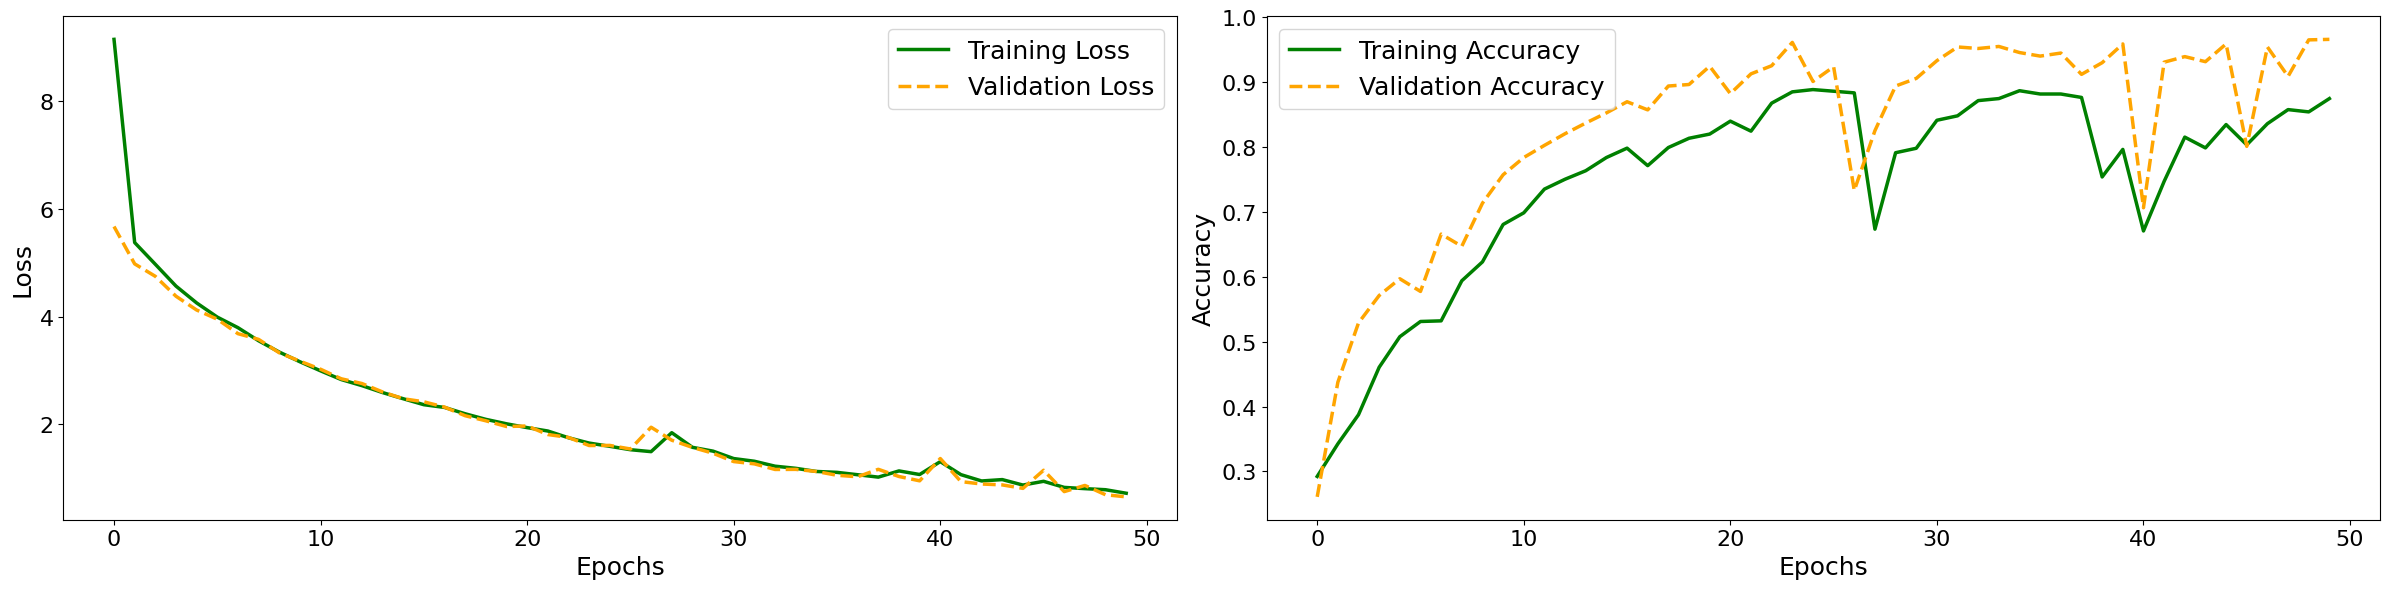

In [64]:
file_name = results_dir_02 / 'history_custom_CNN_best_hp.pkl'
with open(file_name, 'rb') as f:
    history = pickle.load(f)
clear_output(wait=False)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

visualize_training(history)


Overall classification accuracy is: 96.56 %



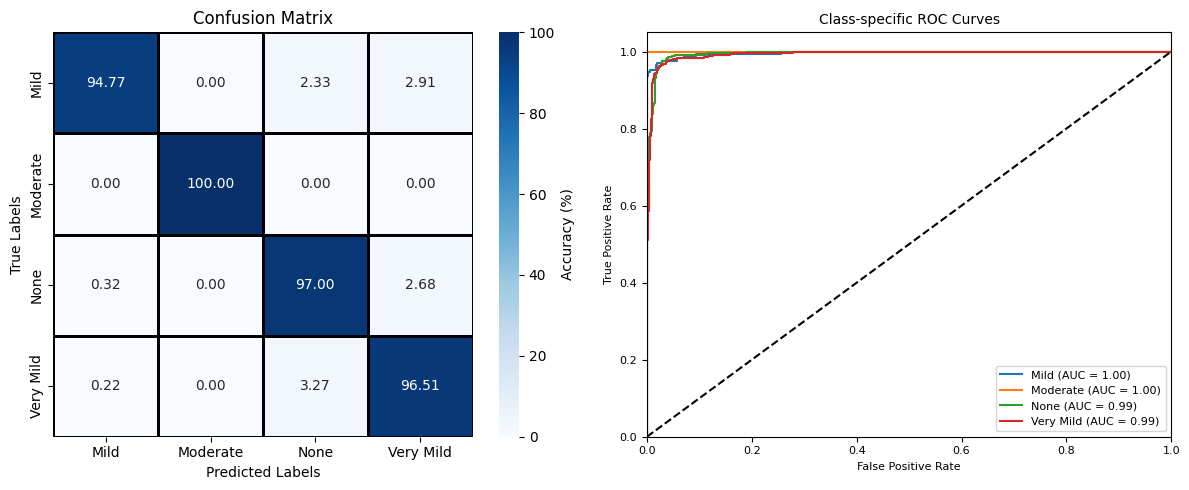

Mild - Precision: 0.98, Recall: 0.95, F1 Score: 0.96
Moderate - Precision: 1.00, Recall: 1.00, F1 Score: 1.00
None - Precision: 0.97, Recall: 0.97, F1 Score: 0.97
Very Mild - Precision: 0.95, Recall: 0.97, F1 Score: 0.96



In [66]:
# Load model
model = load_model(results_dir_02 / 'model_custom_CNN_best_hp.h5')

# Predict test data
prob = model.predict(test_data)
clear_output(wait=False)
predict_classes = np.argmax(prob, axis=1)
result = predict_classes - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary, 0)
acc=correct/test_lab.shape[0] * 100

print()
print(f"Overall classification accuracy is: {acc:.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(prob, test_lab, class_lab)
print()

In this case, hyperparameter tuning resulted in very similar overall classification accuracy compared to "default" settings, as well as consistently high accuracy values across all classes. However, in this case, we do see that the F1 scores for the two minority classes (Mild, Moderate) improved. In particular, the moderate AD class, which is by far the minority class in the entire dataset, now exhibits a 100% validation accuracy. This is in contrast to the unbalanced and untuned model where the accuracy on this class was by far the lowest. While this final model is likely not perfect, the optimized CNN in the end performs well across all classes and overall.